In [1]:
import sys, os
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem, Descriptors
import sklearn
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, precision_score,recall_score, accuracy_score
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('dataset/feature_set_all/train_set_2.csv')
df[df.select_dtypes(np.float64).columns] = df.select_dtypes(np.float64).astype(np.float32)
df.head(2)

,num,name,BBclass,Check,smiles,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,MFP_2039,MFP_2040,MFP_2041,MFP_2042,MFP_2043,MFP_2044,MFP_2045,MFP_2046,MFP_2047,MFP_2048
0,1,Propanolol,1,2,CC(C)NCC(O)COc1cccc2ccccc12,9.843954,-0.498733,9.843954,0.299333,0.837506,...,1,0,0,0,0,0,0,0,0,0
1,2,Terbutylchlorambucil,1,2,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,11.682268,-0.409691,11.682268,0.134704,0.474821,...,0,0,0,0,0,0,0,0,0,0


In [3]:
columns = df.columns.to_numpy()
check_features = columns[df.isin([np.inf, -np.inf, np.NaN]).any(axis=0).to_numpy()].tolist()
check_features, len(check_features)

(['Ipc'], 1)

In [4]:
lowVar_features = df.std()[df.std() < 0.14].index.tolist()
len(lowVar_features)

1351

In [5]:
#features = [x[0] for x in Descriptors._descList]
Fingerprints = ['MFP_%d'%(i+1) for i in range(2048)]
descriptors = ['HeavyAtomMolWt','NHOHCount','NOCount','RingCount']
features = Fingerprints + descriptors
features = [x for x in features if x not in check_features+lowVar_features]
len(features)

743

In [6]:
df.BBclass.value_counts()/len(df)

1    0.763562
0    0.236438
Name: BBclass, dtype: float64

In [7]:
X_train = np.c_[df[features]]
y_train = np.c_[df['BBclass']]

In [8]:
test = pd.read_csv('dataset/feature_set_all/test_set_combined.csv')
X_test = np.c_[test[features]]
y_test = np.c_[test['BBclass']]
len(test)

2563

### 1. Try a standard XGB model 

In [9]:
df_result = pd.DataFrame(columns=['model', 'tp', 'tn', 'fp', 'fn', 'correct', 'incorrect',
                                  'accuracy', 'precision', 'recall', 'f1', 'roc_auc','avg_pre'])

classifier = XGBClassifier(eval_metric='mlogloss',use_label_encoder=False,random_state=10)
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
avg_precision = average_precision_score(y_test, y_pred)

row = {'model': 'XGBClassifier without SMOTE',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': round(accuracy,3),
        'precision': round(precision,3),
        'recall': round(recall,3),
        'f1': round(f1,3),
        'roc_auc': round(roc_auc,3),
        'avg_pre': round(avg_precision,3),
    }

df_result = df_result.append(row, ignore_index=True)
df_result.head()

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,XGBClassifier without SMOTE,1541,609,263,150,2150,413,0.839,0.854,0.911,0.882,0.805,0.837


Text(0.5, 1.0, 'Precision-Recall curve: ~0.8370')

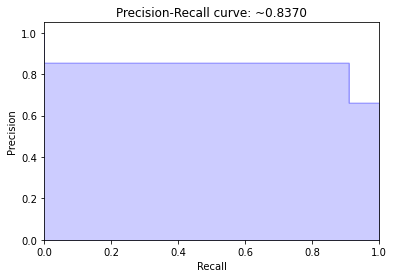

In [10]:
avg_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.00])
plt.title('Precision-Recall curve: ~{0:0.4f}'.format(avg_precision))

### 2. Fit XGB model using SMOTE

In [11]:
oversampled = SMOTE(random_state=10)
X_train_smote, y_train_smote = oversampled.fit_resample(X_train, y_train)

In [12]:
y_train_smote.mean()

0.5

In [13]:
classifier = XGBClassifier(eval_metric='mlogloss',use_label_encoder=False,random_state=10)
model = classifier.fit(X_train_smote, y_train_smote)
y_pred_smote = model.predict(X_test)

In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_smote).ravel()
accuracy = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)
roc_auc = roc_auc_score(y_test, y_pred_smote)
avg_precision = average_precision_score(y_test, y_pred_smote)

row = {'model': 'XGBClassifier with SMOTE',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_pre': round(avg_precision,3),       
    }

In [15]:
df_result = df_result.append(row, ignore_index=True)
df_result

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,XGBClassifier without SMOTE,1541,609,263,150,2150,413,0.83900,0.854000,0.911000,0.882000,0.805000,0.837
1,XGBClassifier with SMOTE,1544,599,273,147,2143,420,0.83613,0.849752,0.913069,0.880274,0.799998,0.833


Text(0.5, 1.0, 'Precision-Recall curve: ~0.8332')

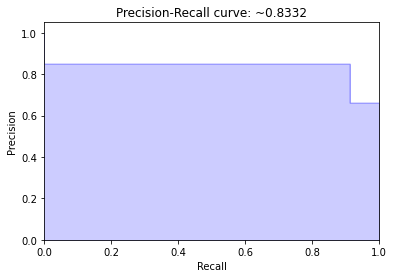

In [16]:
avg_precision = average_precision_score(y_test, y_pred_smote)
precision, recall, _ = precision_recall_curve(y_test, y_pred_smote)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: ~{0:0.4f}'.format(avg_precision))

### 3. Using under-sampling and SMOTE over-sampling

In [17]:
oversampled = SMOTE(sampling_strategy=0.6, 
                    random_state=0,
                    k_neighbors=4)
X_train_smote, y_train_smote = oversampled.fit_resample(X_train, y_train)

In [18]:
y_train_smote.mean()

0.6250523669878508

In [19]:
undersampled = RandomUnderSampler(sampling_strategy=1.0, random_state=0)
X_train_final, y_train_final = undersampled.fit_resample(X_train_smote, y_train_smote)

In [20]:
y_train_final.mean()

0.5

In [21]:
classifier = XGBClassifier(eval_metric='mlogloss',use_label_encoder=False,random_state=10)
model = classifier.fit(X_train_final, y_train_final)
y_pred_smote = model.predict(X_test)

In [22]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_smote).ravel()
accuracy = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)
roc_auc = roc_auc_score(y_test, y_pred_smote)
avg_precision = average_precision_score(y_test, y_pred_smote)

row = {'model': 'XGBClassifier with under/over',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_pre': round(avg_precision,3),       
    }

In [23]:
df_result = df_result.append(row, ignore_index=True)
df_result

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,XGBClassifier without SMOTE,1541,609,263,150,2150,413,0.839000,0.854000,0.911000,0.882000,0.805000,0.837
1,XGBClassifier with SMOTE,1544,599,273,147,2143,420,0.836130,0.849752,0.913069,0.880274,0.799998,0.833
2,XGBClassifier with under/over,1485,651,221,206,2136,427,0.833398,0.870457,0.878179,0.874301,0.812369,0.845


Text(0.5, 1.0, 'Precision-Recall curve: ~0.8448')

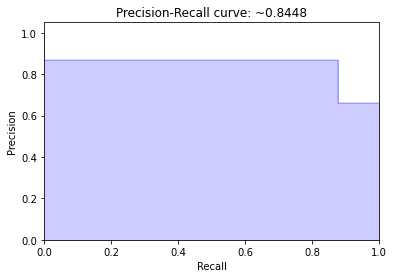

In [24]:
avg_precision = average_precision_score(y_test, y_pred_smote)
precision, recall, _ = precision_recall_curve(y_test, y_pred_smote)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: ~{0:0.4f}'.format(avg_precision))

### 4. Borderline SMOTE

In [25]:
oversampled = BorderlineSMOTE(random_state=0)
X_train_smote, y_train_smote = oversampled.fit_resample(X_train, y_train)

In [26]:
y_train_smote.mean()

0.5

In [27]:
classifier = XGBClassifier(eval_metric='mlogloss',use_label_encoder=False,random_state=10)
model = classifier.fit(X_train_smote, y_train_smote)
y_pred_smote = model.predict(X_test)

In [28]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_smote).ravel()
accuracy = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)
roc_auc = roc_auc_score(y_test, y_pred_smote)
avg_precision = average_precision_score(y_test, y_pred_smote)

row = {'model': 'XGBClassifier with Borderline SMOTE',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_pre': round(avg_precision,3),       
    }

In [29]:
df_result = df_result.append(row, ignore_index=True)
df_result

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,XGBClassifier without SMOTE,1541,609,263,150,2150,413,0.839000,0.854000,0.911000,0.882000,0.805000,0.837
1,XGBClassifier with SMOTE,1544,599,273,147,2143,420,0.836130,0.849752,0.913069,0.880274,0.799998,0.833
2,XGBClassifier with under/over,1485,651,221,206,2136,427,0.833398,0.870457,0.878179,0.874301,0.812369,0.845
3,XGBClassifier with Borderline SMOTE,1544,603,269,147,2147,416,0.837690,0.851627,0.913069,0.881279,0.802291,0.835


### 5. Compared with Balanced RF Classifier

In [30]:
from imblearn.ensemble import BalancedRandomForestClassifier

classifier = BalancedRandomForestClassifier(n_estimators=400,
                                          criterion='gini',
                                          oob_score=True, random_state=10)

model = classifier.fit(X_train, y_train[:,0])
y_pred_RF = model.predict(X_test)

In [31]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_RF).ravel()
accuracy = accuracy_score(y_test, y_pred_RF)
precision = precision_score(y_test, y_pred_RF)
recall = recall_score(y_test, y_pred_RF)
f1 = f1_score(y_test, y_pred_RF)
roc_auc = roc_auc_score(y_test, y_pred_RF)
avg_precision = average_precision_score(y_test, y_pred_RF)

row = {'model': 'Balanced RF Classifier',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_pre': round(avg_precision,3),       
    }

In [32]:
df_result = df_result.append(row, ignore_index=True)
df_result

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,XGBClassifier without SMOTE,1541,609,263,150,2150,413,0.839000,0.854000,0.911000,0.882000,0.805000,0.837
1,XGBClassifier with SMOTE,1544,599,273,147,2143,420,0.836130,0.849752,0.913069,0.880274,0.799998,0.833
2,XGBClassifier with under/over,1485,651,221,206,2136,427,0.833398,0.870457,0.878179,0.874301,0.812369,0.845
3,XGBClassifier with Borderline SMOTE,1544,603,269,147,2147,416,0.837690,0.851627,0.913069,0.881279,0.802291,0.835
4,Balanced RF Classifier,1452,683,189,239,2135,428,0.833008,0.884826,0.858664,0.871549,0.820960,0.853


### 6. Compared with standard RF Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=400,
                                          criterion='gini',
                                          oob_score=True, random_state=10)

model = classifier.fit(X_train, y_train[:,0])
y_pred_RF = model.predict(X_test)

In [34]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_RF).ravel()
accuracy = accuracy_score(y_test, y_pred_RF)
precision = precision_score(y_test, y_pred_RF)
recall = recall_score(y_test, y_pred_RF)
f1 = f1_score(y_test, y_pred_RF)
roc_auc = roc_auc_score(y_test, y_pred_RF)
avg_precision = average_precision_score(y_test, y_pred_RF)

row = {'model': 'RF Classifier',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_pre': round(avg_precision,3),       
    }

In [35]:
df_result = df_result.append(row, ignore_index=True)
df_result

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,XGBClassifier without SMOTE,1541,609,263,150,2150,413,0.839000,0.854000,0.911000,0.882000,0.805000,0.837
1,XGBClassifier with SMOTE,1544,599,273,147,2143,420,0.836130,0.849752,0.913069,0.880274,0.799998,0.833
2,XGBClassifier with under/over,1485,651,221,206,2136,427,0.833398,0.870457,0.878179,0.874301,0.812369,0.845
3,XGBClassifier with Borderline SMOTE,1544,603,269,147,2147,416,0.837690,0.851627,0.913069,0.881279,0.802291,0.835
4,Balanced RF Classifier,1452,683,189,239,2135,428,0.833008,0.884826,0.858664,0.871549,0.820960,0.853
5,RF Classifier,1589,553,319,102,2142,421,0.835739,0.832809,0.939681,0.883023,0.786927,0.822


In [36]:
df_result.to_csv('results/eval_on_enlarged_test.csv', index=False)